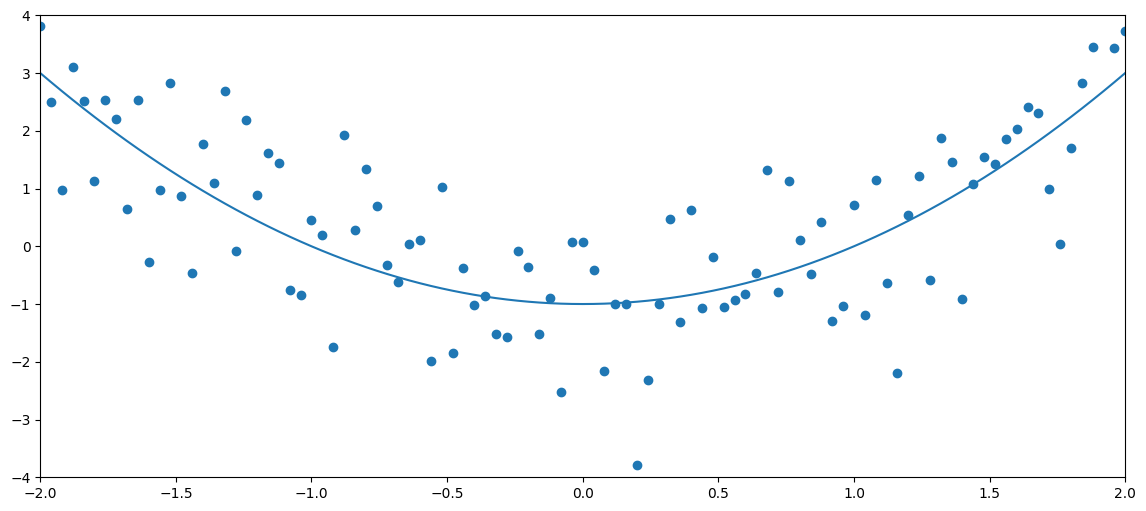

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import csv
from numpy import genfromtxt

quad = lambda x: x**2 - 1
t = np.linspace(-2, 2, 101)
noise = np.random.normal(0, 1, len(t))

# data0 = list(map(quad, t))
data0 = genfromtxt('array.csv', delimiter=',')
data = genfromtxt('arrayN.csv', delimiter=',')
# data = data0 + noise

# np.savetxt('array.csv', data0, delimiter=',')
# np.savetxt('arrayN.csv', data, delimiter=',')

plt.figure(figsize = (14,6))

ax = plt.gca()
ax.set_xlim([-2, 2])
ax.set_ylim([-4, 4])

plt.plot(t, data0)
plt.scatter(t, data)
plt.show()
# np.array()

(51,) (50,) (51,) (50,)


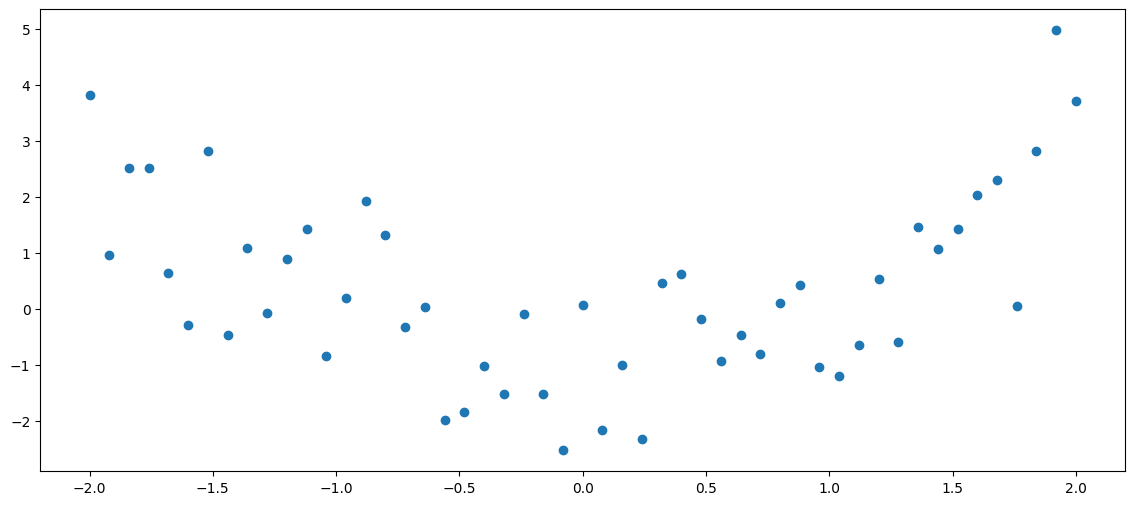

In [2]:
ones = np.ones((1,len(t))) # col
X = np.concatenate([ones, t.reshape((1,len(t))), t.reshape((1,len(t)))**2]).T
alpha_ls = np.linalg.pinv(X)@data

s = 2
t_len = len(t)

dataHalf = data[0:t_len:s]
dataHalf_valid = data[1:t_len:s]

X_half = X[0:t_len:s, :]
t_s = t[0:t_len:s]
t_s_valid = t[1:t_len:s]

print(dataHalf.shape, dataHalf_valid.shape, t_s.shape, t_s_valid.shape)

plt.figure(figsize = (14,6))
plt.scatter(t_s, dataHalf)
plt.show()

### Degree not known and Overfit

In [3]:
min_diff = 10000000
a_pred = []
argDeg = 0
ones = np.ones((1,len(t))) # col
X_0 = ones

import os

# X = np.concatenate([ones, t.reshape((1,len(t))), t.reshape((1,len(t)))**2]).T
alpha_OF = []
for deg in range(1, 8): # given no specific degree of polynomial
    X_0 = np.concatenate([X_0, (t.reshape((1,len(t)))**deg)]) # starts from linear deg=1, ax+b
    X = X_0.T
    
    # Remove the i-th row from X and data to create a "leave-one-out" set
    X_half = X[0:101:s, :]
    Xtrain = X_half
    dataTrain = dataHalf
    alpha = np.linalg.pinv(Xtrain) @ dataTrain
    #a1, a2, a3 = alpha[0], alpha[1], alpha[2]
    
    # Predict for the excluded point (dataHalfsol[i])
    data_pred = sum(alpha[j]*(t_s**j) for j in range(0, deg+1)) #a1 + a2 * t[i] + a3 * t[i]**2
    # print(data_pred.shape, dataHalfsol.shape)
    diff = sum((dataHalf - data_pred)**2)
    
    # Check if the prediction minimizes SSE
    if diff < min_diff:
        # print(f'{diff} < {min_diff}')
        min_diff = diff
        argDeg = deg+1
        a_pred_OF = alpha
    print(f'Shape: alpha={alpha.shape}, X={X.shape}, argDeg={argDeg}')


Shape: alpha=(2,), X=(101, 2), argDeg=2
Shape: alpha=(3,), X=(101, 3), argDeg=3
Shape: alpha=(4,), X=(101, 4), argDeg=4
Shape: alpha=(5,), X=(101, 5), argDeg=5
Shape: alpha=(6,), X=(101, 6), argDeg=6
Shape: alpha=(7,), X=(101, 7), argDeg=7
Shape: alpha=(8,), X=(101, 8), argDeg=8


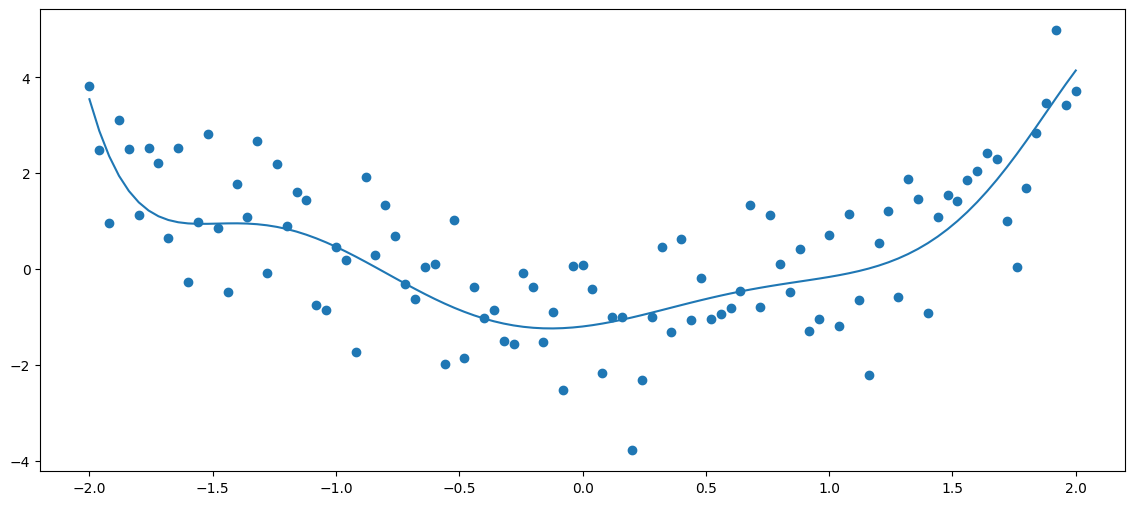

In [4]:
plt.figure(figsize = (14,6))
plt.plot(t,  sum(a_pred_OF[j]*(t**j) for j in range(0, len(a_pred_OF))))
plt.scatter(t, data)
plt.show()

In [5]:
# pred = lambda x: a_pred[0] + a_pred[1]*x + a_pred[2]*x**2+a_pred[3]*x**3

OF_result = np.array([sum(a_pred_OF[j]*(t**j) for j in range(0, len(alpha)))]).squeeze()

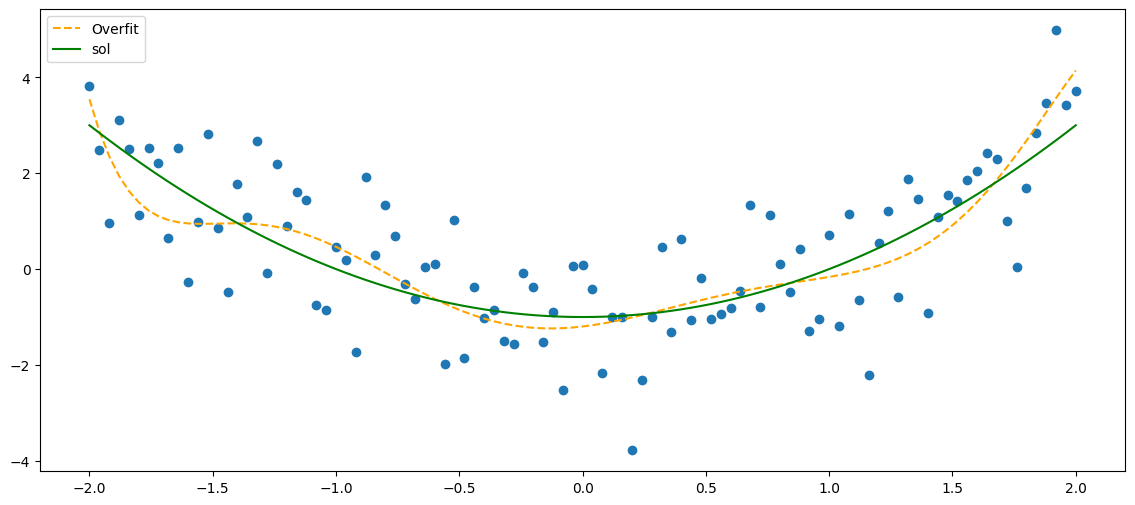

In [6]:
plt.figure(figsize = (14,6))
plt.scatter(t, data)
plt.plot(t, OF_result, linestyle='--', color = 'orange', label="Overfit")
plt.plot(t, data0, color = 'green', label="sol")

plt.legend()
plt.show()
# Handling overfit will be implemented later

### Handling overfit using 50% of data for training and validation

In [7]:
# HANDLING OVERFIT by splitting data into half training and half validation
# maybe regularization is also required to get degree=2
min_diff = 10000000
a_pred = []
argDeg = 0
ones = np.ones((1,len(t))) # col
X_0 = ones

Xtrain = X_half
dataTrain = dataHalf

alpha_OF = [] # for overfitting coefficients
for deg in range(1, 8): # given no specific degree of polynomial, search the best-fitting polynomial
    X_0 = np.concatenate([X_0, (t.reshape((1,t_len))**deg)]) # starts from linear deg=1, ax+b
    X = X_0.T
    
    # Remove the i-th row from X and data to create a "leave-one-out" set
    X_half = X[0:101:s, :]
    Xtrain = X_half
    
    alpha = np.linalg.pinv(Xtrain) @ dataTrain
    
    # Predict
    data_pred = sum(alpha[j]*(t_s**j) for j in range(0, deg+1))
    pred_valid = sum([alpha[j]*(t_s_valid**j) for j in range(0, deg+1)])
    diff_valid = sum((dataHalf_valid - pred_valid)**2)
    
    # Check if the prediction minimizes SSE
    if diff_valid < min_diff:
        min_diff = diff_valid
        argDeg = deg+1
        a_pred_OF = alpha
    print(f'Shape: alpha={alpha.shape}, X={X.shape}, argDeg={argDeg}')

Shape: alpha=(2,), X=(101, 2), argDeg=2
Shape: alpha=(3,), X=(101, 3), argDeg=3
Shape: alpha=(4,), X=(101, 4), argDeg=4
Shape: alpha=(5,), X=(101, 5), argDeg=4
Shape: alpha=(6,), X=(101, 6), argDeg=4
Shape: alpha=(7,), X=(101, 7), argDeg=4
Shape: alpha=(8,), X=(101, 8), argDeg=4


In [8]:
a_pred_OF

array([-1.05808782, -0.33443321,  1.02503946,  0.16330554])

In [9]:
deg4 = np.array([sum(a_pred_OF[j]*(t_s**j) for j in range(0, len(a_pred_OF)))])

(51,) (51,)


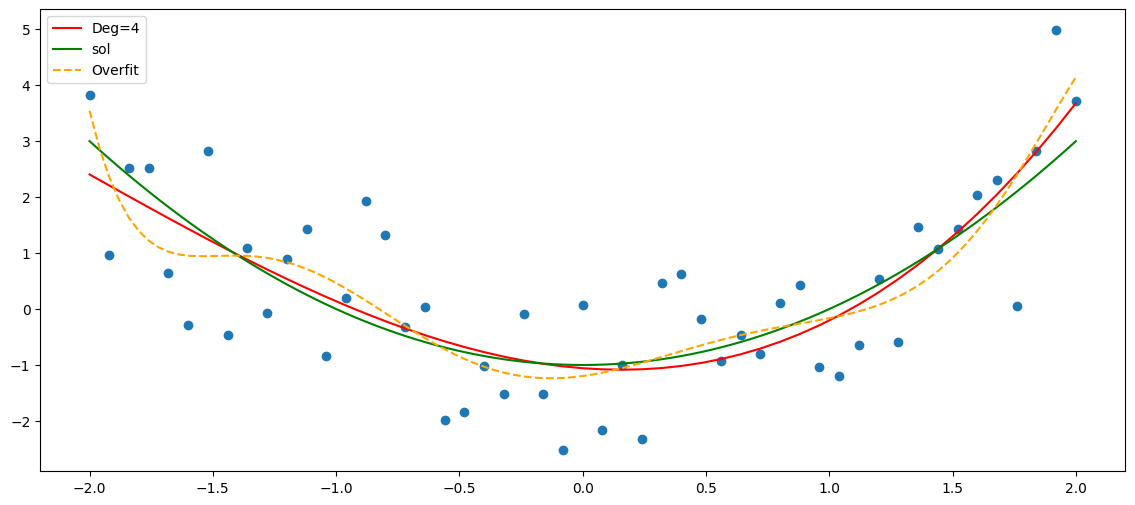

In [10]:
plt.figure(figsize = (14,6))
plt.plot(t_s,  deg4.T, label="Deg=4", color="red")
print(t_s.shape, dataHalf.shape)
plt.scatter(t_s, dataHalf)
plt.plot(t, data0, color = 'green', label="sol")
plt.plot(t, OF_result, linestyle='--', color = 'orange', label="Overfit")

plt.legend()
plt.show()
# better complexity

### Degree is known and fixed

In [11]:
# Prepare for next step
ones = np.ones((1,len(t))) # col
X = np.concatenate([ones, t.reshape((1,len(t))), t.reshape((1,len(t)))**2]).T
dataHalf = data[0:t_len:s]
dataHalf
X_half = X[0:t_len:s, :]
print()

In [12]:
# If the degree to use is known and fixed to 2
# LEAVE_ONE_OUT using for loop, take one row for a test
# and compute SSE and keep the result that minimizes the SSE
min_diff = 10000000
a_pred = []

for i in range(len(dataHalf)):
    # Remove the i-th row from X and data to create a "leave-one-out" set
    Xtrain = np.delete(X_half, i, axis=0)
    dataTrain = np.delete(dataHalf, i)
    alpha = np.linalg.pinv(Xtrain) @ dataTrain
    # print(alpha.shape)
    a1, a2, a3 = alpha[0], alpha[1], alpha[2]
    
    # Predict for the excluded point (dataHal[i])
    data_pred = np.array([a1 + a2*t_s[j] + a3*t_s[j]**2 for j in range(0, len(t_s))])
    # print(data_pred.shape, dataHal.shape)
    diff = (dataHalf[i] - data_pred[i]) ** 2
    
    # Check if the prediction minimizes SSE
    if diff < min_diff:
        min_diff = diff
        a_pred = [a1, a2, a3]

print(a_pred)

[-1.0581103031024746, 0.07282022283279849, 1.0249581972683108]


(51,) (51,)


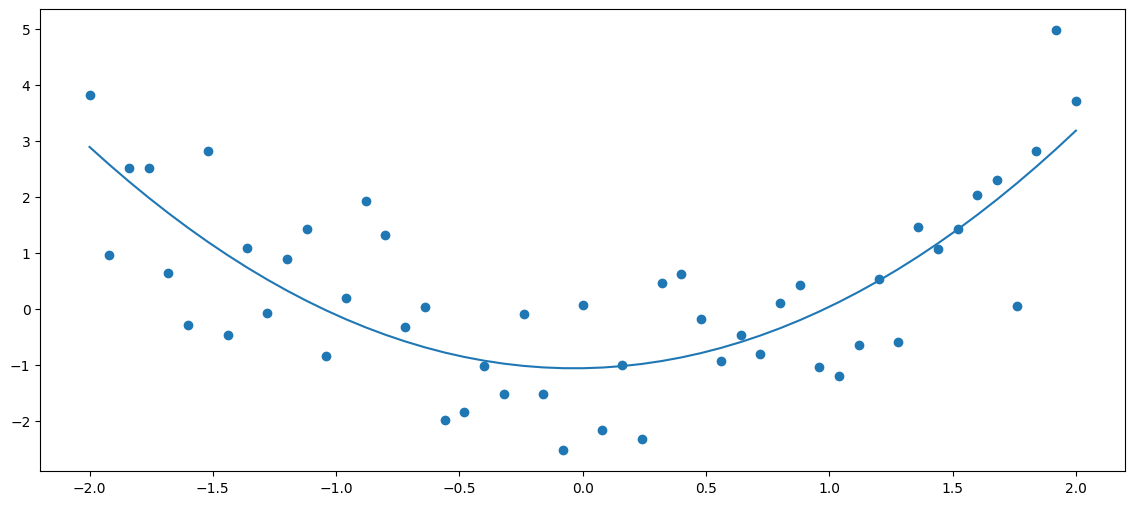

In [13]:
plt.figure(figsize = (14,6))
plt.plot(t_s,  sum(a_pred[j]*(t_s**j) for j in range(0, len(a_pred))))
print(t_s.shape, dataHalf.shape)
plt.scatter(t_s, dataHalf)
plt.show()

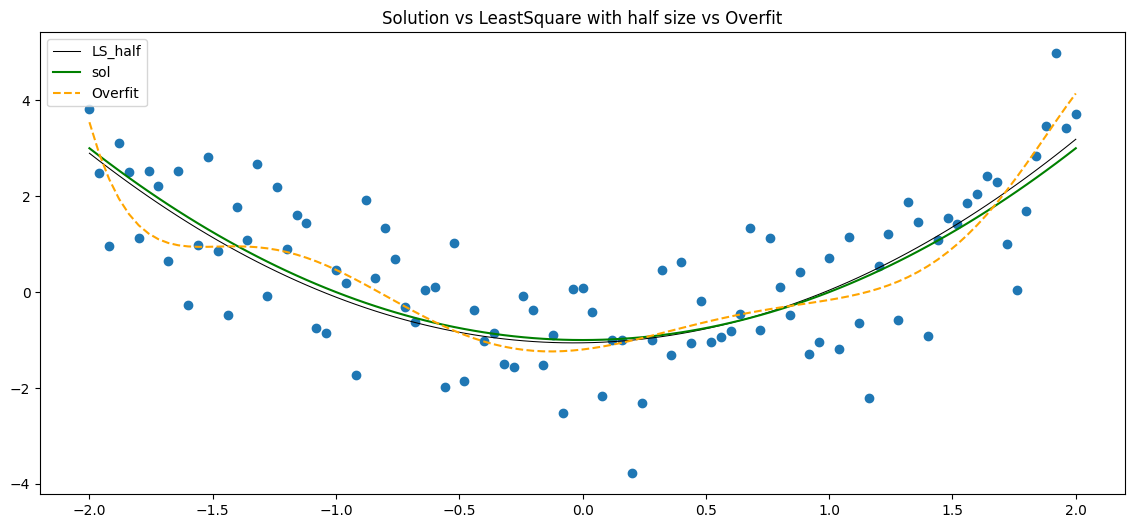

In [14]:
pred = lambda x: a_pred[0] + a_pred[1]*x + a_pred[2]*x**2
plt.figure(figsize = (14,6))
plt.scatter(t, data) # blue dots
# plt.plot(t, pred(t), color = 'black', label="LS_half", linewidth=0.75)
plt.plot(t, pred(t), color = 'black', label="LS_half", linewidth=0.75)
plt.plot(t, data0, color = 'green', label="sol")
# plt.scatter(t_s, pred(t[0:t_len:s]))

plt.title("Solution vs LeastSquare with half size vs Overfit")
plt.plot(t, OF_result, linestyle='--', color = 'orange', label="Overfit")

plt.legend()
plt.show()
# less data points available makes less accurate, but still not bad

### Regularization

Shape: alpha=(2,), X=(101, 2), argDeg=2
Shape: alpha=(3,), X=(101, 3), argDeg=3
Shape: alpha=(4,), X=(101, 4), argDeg=4
Shape: alpha=(5,), X=(101, 5), argDeg=4
Shape: alpha=(6,), X=(101, 6), argDeg=4
Shape: alpha=(7,), X=(101, 7), argDeg=4
Shape: alpha=(8,), X=(101, 8), argDeg=4
Validated: 2.682127468419795
Ridge: 4.997999538071278


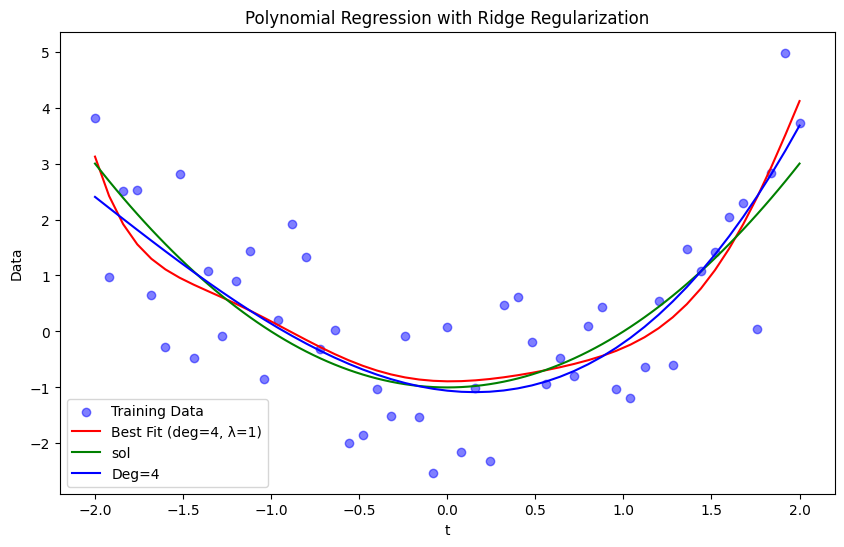

In [27]:
# Regularization parameter
lambda_reg = 1

min_diff = 10000000
a_pred_OF = []
argDeg = 0
ones = np.ones((1, len(t)))  # Column of ones for the intercept term
X_0 = ones

Xtrain = X_half
dataTrain = dataHalf

alpha_OF = []

for deg in range(1, 8): # Polynomial degrees from 1 to 7
    X_0 = np.concatenate([X_0, (t.reshape((1, len(t))) ** deg)])  # Polynomial terms
    X = (X_0).T

    # Remove the i-th row from X and data to create a "leave-one-out" set
    X_half = X[0:101:s, :]
    Xtrain = X_half

    # Ridge Regression: Add lambda_reg * I to X^T * X
    I = np.eye(Xtrain.shape[1])
    alpha = np.linalg.inv(Xtrain.T @ Xtrain + lambda_reg * I) @ Xtrain.T @ dataTrain

    # Predict
    data_pred = sum(alpha[j] * (t_s ** j) for j in range(0, deg + 1))
    pred_valid = sum([alpha[j] * (t_s_valid ** j) for j in range(0, deg + 1)])
    diff_valid = sum((dataHalf_valid - pred_valid) ** 2)

    # Check if the prediction minimizes SSE
    if diff_valid < min_diff:
        min_diff = diff_valid
        argDeg = deg + 1
        a_pred_OF = alpha

    print(f'Shape: alpha={alpha.shape}, X={X.shape}, argDeg={argDeg}')

# Losses
print(f'Validated: {np.sum((data0[0:101:2] - deg4)**2)}')
print(f'Ridge: {np.sum((data0[0:101:2] - data_pred)**2)}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(t_s, dataHalf, label="Training Data", color="blue", alpha=0.5)
plt.plot(t_s, data_pred, label=f"Best Fit (deg={argDeg}, λ={lambda_reg})", color="red")
plt.plot(t, data0, color = 'green', label="sol")
plt.plot(t_s, deg4.T, label="Deg=4", color="blue")
plt.legend()
plt.title("Polynomial Regression with Ridge Regularization")
plt.xlabel("t")
plt.ylabel("Data")
plt.show()

# L2 reg did not work well

[-0.90029067  0.0369107   0.94733341]


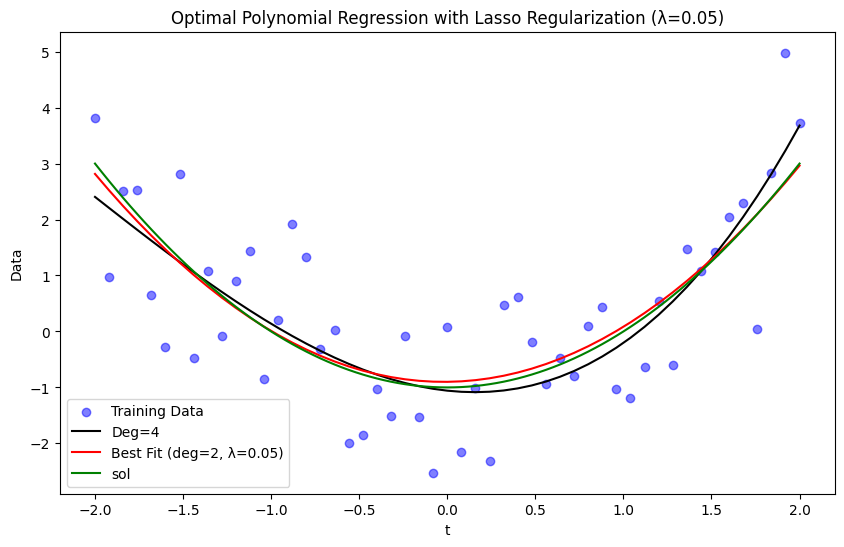

In [28]:
from sklearn.linear_model import Lasso
import pandas

# Regularization parameter for Lasso, and try 0.01 and 0.1. 0.05 looks better optimal
lambda_lasso = 0.05

min_diff = float('inf')
best_deg = None
best_alpha = None
best_pred = None

X_0 = np.ones((1, len(t)))

for deg in range(1, 8): 
    X_0 = np.concatenate([X_0, (t.reshape((1, len(t))) ** deg)])
    X = X_0.T

    X_half = X[0:101:s, :] # Training with only 50% of data because that's how deg4 was trained
    Xtrain = X_half

    # Lasso
    lasso_model = Lasso(alpha=lambda_lasso, fit_intercept=False, max_iter=10000)
    lasso_model.fit(Xtrain, dataTrain)
    alpha = lasso_model.coef_

    # Predict
    data_pred = sum(alpha[j] * (t_s ** j) for j in range(0, deg + 1))
    pred_valid = sum([alpha[j] * (t_s_valid ** j) for j in range(0, deg + 1)])
    diff_valid = sum((dataHalf_valid - pred_valid) ** 2)

    # Check if the prediction minimizes SSE
    if diff_valid < min_diff:
        min_diff = diff_valid
        best_deg = deg + 1
        best_alpha = alpha
        best_pred = data_pred
print(best_alpha)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(t_s, dataHalf, label="Training Data", color="blue", alpha=0.5)
plt.plot(t_s,  deg4.T, label="Deg=4", color="black")
plt.plot(t_s, best_pred, label=f"Best Fit (deg={best_deg-1}, λ={lambda_lasso})", color="red")
plt.plot(t, data0, color = 'green', label="sol")
plt.legend()
plt.title(f"Optimal Polynomial Regression with Lasso Regularization (λ={lambda_lasso})")
plt.xlabel("t")
plt.ylabel("Data")
plt.show()

# seems working well